In [333]:
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 90

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('tweet_list2.csv')
for n in df.columns:
    df[n] = df[n].astype(str)
df.dtypes
df.info()
df['user_name'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115511 entries, 0 to 115510
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_name   115511 non-null  object
 1   class       115511 non-null  object
 2   id          115511 non-null  object
 3   text        115511 non-null  object
 4   author_id   115511 non-null  object
 5   created_at  115511 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


WSJbusiness        1606
wealth              850
YahooFinance        850
ScienceMagazine     850
Google              850
                   ... 
repvalhoyle          10
JMoylanforGuam       10
NBCNetwork            7
RepJeffJackson        2
DNC                   1
Name: user_name, Length: 586, dtype: int64

Check for duplicates

In [3]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
115506    False
115507    False
115508    False
115509    False
115510    False
Length: 115511, dtype: bool

Drop duplicates

In [4]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114634 entries, 0 to 115510
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_name   114634 non-null  object
 1   class       114634 non-null  object
 2   id          114634 non-null  object
 3   text        114634 non-null  object
 4   author_id   114634 non-null  object
 5   created_at  114634 non-null  object
dtypes: object(6)
memory usage: 6.1+ MB


Check class balance

In [5]:
df['class'].value_counts()

Politics - Conservative    31032
Politics - Liberal         26998
TV / movies                12007
Sports                     12000
Music                      11600
Business and finance        8452
Science / Technology        7550
Travel                      4995
Name: class, dtype: int64

Pre-processing

Data transformation functions

In [6]:
def strip_rt_user(text):
    if text[0:2] == "RT":
        colon = text.find(":")
        return text[colon+1:].lower()
    else:
        return text.lower()

def get_rt_user(text):
    if text[0:2] == "RT":
        colon = text.find(":")
        user = text[:colon]
        at = user.find("@")
        return (user[at+1:]).lower()
    else:
        return ""

def addHashTags(text):
    return "#" + text + "#"
    
def strip_links(text):
    tokens = text.split()
    
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def remove_characters(text, char_to_remove):
    str1 = ''.join(x for x in text if not x in char_to_remove)
    return str1

def remove_punctuation(text):
    text = remove_characters(text, string.punctuation)
    return text


In [7]:
df

,user_name,class,id,text,author_id,created_at
0,BennieGThompson,Politics - Liberal,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00
1,BennieGThompson,Politics - Liberal,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00
2,BennieGThompson,Politics - Liberal,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00
3,BennieGThompson,Politics - Liberal,1620116109864357888,https://t.co/Ze7ePCUJJ2,82453460,2023-01-30 17:45:55+00:00
4,BennieGThompson,Politics - Liberal,1620061909113516036,https://t.co/ley5hNsz0y https://t.co/RFdTeGXGO1,82453460,2023-01-30 14:10:33+00:00
...,...,...,...,...,...,...
115506,RepLCD,Politics - Conservative,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00
115507,RepLCD,Politics - Conservative,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00
115508,RepLCD,Politics - Conservative,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00
115509,RepLCD,Politics - Conservative,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00


In [8]:
df2 = df.copy()
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Constants 
min_word_size = 0
min_word_count = 0

# Make special user names and retweet names, and pull it out from the text tweet
df2['text2'] = df2['text'].apply(strip_rt_user)
df2['RT_user'] = df2['text'].apply(get_rt_user)
df2['RT_user#'] = df2['RT_user'].apply(lambda x: addHashTags(x) if x != "" else "")

# Lower case the text tweets
df2['text2'] = df2['text2'].str.lower()

# Strip out the meaningless links
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n[0:4] != "http"]))

# Strip any excess white space
df2['text2'] = df2['text2'].apply(lambda x: x.strip())

# Take out stop words
sw = set(stopwords.words('english'))
sw.update(['amp'])
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n not in sw]))

# Remove punctuation
df2['text2'] = df2['text2'].apply(lambda x: remove_punctuation(x))

# min length of characters for word
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if len(n) >= min_word_size]))

# Make sure we don't have any random numbers
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n.isnumeric() == False]))

# Stem the words
#sb = SnowballStemmer(language='english')
#df2['text2'] = df2['text2'].apply(lambda x: " ".join([sb.stem(n) for n in x.split()]))

# Put it all together in a new column
df2['text2'] = df2['text2'] + " " + df2['RT_user#']

# Limit data to tweets that have greater than specific number of words
df2['word_count'] = df2['text2'].apply(lambda x: len(x))
df2 = df2[ df2['word_count'] >= min_word_count ]

# Make a new column, tokenize the words
df2['text3'] = df2['text2'].str.split()

# Make a new df
df3 = df2.copy()
df3['text3'] = df3['text3'].apply(lambda x: np.nan if len(x) == 0 else x)
df3 = df3.dropna().reset_index(drop=True) 
df3





,user_name,class,id,text,author_id,created_at,text2,RT_user,RT_user#,word_count,text3
0,BennieGThompson,Politics - Liberal,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00,today marks 83rd anniversary first ever socialsecurity check republicans celebrating t...,,,180,"[today, marks, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cel..."
1,BennieGThompson,Politics - Liberal,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00,president biden getting started #vp#,vp,#vp#,36,"[president, biden, getting, started, #vp#]"
2,BennieGThompson,Politics - Liberal,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00,never negotiate away health safety economic wellbeing american people #repjeffries#,repjeffries,#repjeffries#,83,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje..."
3,BennieGThompson,Politics - Liberal,1619330126361300993,The footage of Tyre Nichols killing is painful. I send my condolences to his family an...,82453460,2023-01-28 13:42:42+00:00,footage tyre nichols killing painful send condolences family friends justice must serv...,,,101,"[footage, tyre, nichols, killing, painful, send, condolences, family, friends, justice..."
4,BennieGThompson,Politics - Liberal,1619327606159179777,RT @CBCInstitute: Happy Birthday to our Chairman Congressman @BennieGThompson! In your...,82453460,2023-01-28 13:32:41+00:00,happy birthday chairman congressman benniegthompson 30th yr congress celebrate incredi...,cbcinstitute,#cbcinstitute#,108,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat..."
...,...,...,...,...,...,...,...,...,...,...,...
112722,RepLCD,Politics - Conservative,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00,great catch friend repfeenstra last night were ready get work amp deliver promises mad...,,,114,"[great, catch, friend, repfeenstra, last, night, were, ready, get, work, amp, deliver,..."
112723,RepLCD,Politics - Conservative,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00,thank or05 placing trust represent halls congress solemn promise oregonians carry cons...,,,155,"[thank, or05, placing, trust, represent, halls, congress, solemn, promise, oregonians,..."
112724,RepLCD,Politics - Conservative,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00,small minority preventing house work sent do must get economy back track work get cost...,,,157,"[small, minority, preventing, house, work, sent, do, must, get, economy, back, track, ..."
112725,RepLCD,Politics - Conservative,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00,take responsibility serving or05 im grateful family side,,,57,"[take, responsibility, serving, or05, im, grateful, family, side]"


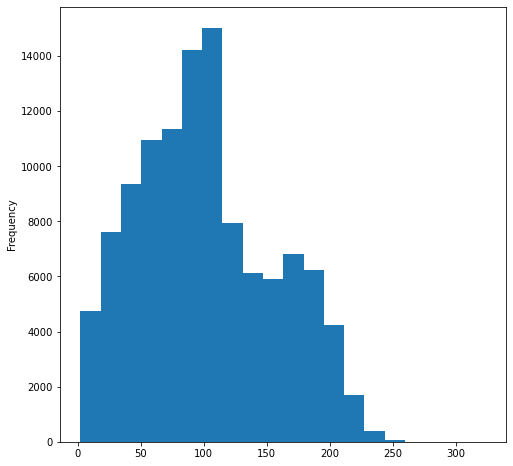

In [9]:
ax = df3['word_count'].plot.hist(figsize=(8,8), bins=20)

First try to predict Political affiliation.  Then move on to the others.

In [207]:
df3.loc[(df3['class'] == 'Politics - Conservative') | (df3['class'] == 'Politics - Liberal'), 'class'] = 'Politics'
df3['class'].value_counts()

Politics                57378
TV / movies             11843
Sports                  11633
Music                   10916
Business and finance     8444
Science / Technology     7522
Travel                   4991
Name: class, dtype: int64

In [208]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df3['class_label'] = le.fit_transform(df3['class'])

In [209]:
labels = df3.groupby(['class', 'class_label'])['class',].count()
labels

,,class
class,class_label,
Business and finance,0,8444
Music,1,10916
Politics,2,57378
Science / Technology,3,7522
Sports,4,11633
TV / movies,5,11843
Travel,6,4991


In [210]:
len(df3)
df3

,user_name,class,id,text,author_id,created_at,text2,RT_user,RT_user#,word_count,text3,class_label,text4
0,BennieGThompson,Politics,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00,today marks 83rd anniversary first ever socialsecurity check republicans celebrating t...,,,180,"[today, marks, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cel...",2,"[today, mark, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cele..."
1,BennieGThompson,Politics,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00,president biden getting started #vp#,vp,#vp#,36,"[president, biden, getting, started, #vp#]",2,"[president, biden, get, start, #vp#]"
2,BennieGThompson,Politics,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00,never negotiate away health safety economic wellbeing american people #repjeffries#,repjeffries,#repjeffries#,83,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje...",2,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje..."
3,BennieGThompson,Politics,1619330126361300993,The footage of Tyre Nichols killing is painful. I send my condolences to his family an...,82453460,2023-01-28 13:42:42+00:00,footage tyre nichols killing painful send condolences family friends justice must serv...,,,101,"[footage, tyre, nichols, killing, painful, send, condolences, family, friends, justice...",2,"[footage, tyre, nichols, kill, painful, send, condolence, family, friends, justice, mu..."
4,BennieGThompson,Politics,1619327606159179777,RT @CBCInstitute: Happy Birthday to our Chairman Congressman @BennieGThompson! In your...,82453460,2023-01-28 13:32:41+00:00,happy birthday chairman congressman benniegthompson 30th yr congress celebrate incredi...,cbcinstitute,#cbcinstitute#,108,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat...",2,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112722,RepLCD,Politics,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00,great catch friend repfeenstra last night were ready get work amp deliver promises mad...,,,114,"[great, catch, friend, repfeenstra, last, night, were, ready, get, work, amp, deliver,...",2,"[great, catch, friend, repfeenstra, last, night, be, ready, get, work, amp, deliver, p..."
112723,RepLCD,Politics,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00,thank or05 placing trust represent halls congress solemn promise oregonians carry cons...,,,155,"[thank, or05, placing, trust, represent, halls, congress, solemn, promise, oregonians,...",2,"[thank, or05, place, trust, represent, hall, congress, solemn, promise, oregonian, car..."
112724,RepLCD,Politics,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00,small minority preventing house work sent do must get economy back track work get cost...,,,157,"[small, minority, preventing, house, work, sent, do, must, get, economy, back, track, ...",2,"[small, minority, prevent, house, work, send, do, must, get, economy, back, track, wor..."
112725,RepLCD,Politics,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00,take responsibility serving or05 im grateful family side,,,57,"[take, responsibility, serving, or05, im, grateful, fa

In [211]:
def tag_and_lemmatize(text):
    newText = text
    newText = pos_tag(newText)
    newText = [(x[0], get_wordnet_pos(x[1])) for x in newText]
    lemma = nltk.stem.WordNetLemmatizer()
    newText = [(lemma.lemmatize(x[0], x[1])) for x in newText]
    return newText


In [212]:
df3['text4'] = df3['text3'].apply(tag_and_lemmatize)

In [213]:
df3['text4'][0]

['today',
 'mark',
 '83rd',
 'anniversary',
 'first',
 'ever',
 'socialsecurity',
 'check',
 'republicans',
 'celebrate',
 'try',
 'cut',
 'vital',
 'program',
 'determine',
 'protect',
 'expand',
 'program',
 'american',
 'worker',
 'pay',
 'every',
 'paycheck']

In [214]:
df3

,user_name,class,id,text,author_id,created_at,text2,RT_user,RT_user#,word_count,text3,class_label,text4
0,BennieGThompson,Politics,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00,today marks 83rd anniversary first ever socialsecurity check republicans celebrating t...,,,180,"[today, marks, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cel...",2,"[today, mark, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cele..."
1,BennieGThompson,Politics,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00,president biden getting started #vp#,vp,#vp#,36,"[president, biden, getting, started, #vp#]",2,"[president, biden, get, start, #vp#]"
2,BennieGThompson,Politics,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00,never negotiate away health safety economic wellbeing american people #repjeffries#,repjeffries,#repjeffries#,83,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje...",2,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje..."
3,BennieGThompson,Politics,1619330126361300993,The footage of Tyre Nichols killing is painful. I send my condolences to his family an...,82453460,2023-01-28 13:42:42+00:00,footage tyre nichols killing painful send condolences family friends justice must serv...,,,101,"[footage, tyre, nichols, killing, painful, send, condolences, family, friends, justice...",2,"[footage, tyre, nichols, kill, painful, send, condolence, family, friends, justice, mu..."
4,BennieGThompson,Politics,1619327606159179777,RT @CBCInstitute: Happy Birthday to our Chairman Congressman @BennieGThompson! In your...,82453460,2023-01-28 13:32:41+00:00,happy birthday chairman congressman benniegthompson 30th yr congress celebrate incredi...,cbcinstitute,#cbcinstitute#,108,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat...",2,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112722,RepLCD,Politics,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00,great catch friend repfeenstra last night were ready get work amp deliver promises mad...,,,114,"[great, catch, friend, repfeenstra, last, night, were, ready, get, work, amp, deliver,...",2,"[great, catch, friend, repfeenstra, last, night, be, ready, get, work, amp, deliver, p..."
112723,RepLCD,Politics,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00,thank or05 placing trust represent halls congress solemn promise oregonians carry cons...,,,155,"[thank, or05, placing, trust, represent, halls, congress, solemn, promise, oregonians,...",2,"[thank, or05, place, trust, represent, hall, congress, solemn, promise, oregonian, car..."
112724,RepLCD,Politics,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00,small minority preventing house work sent do must get economy back track work get cost...,,,157,"[small, minority, preventing, house, work, sent, do, must, get, economy, back, track, ...",2,"[small, minority, prevent, house, work, send, do, must, get, economy, back, track, wor..."
112725,RepLCD,Politics,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00,take responsibility serving or05 im grateful family side,,,57,"[take, responsibility, serving, or05, im, grateful, fa

In [215]:
#df3.to_csv('all_lemmatized.csv')

In [216]:
#df3 = pd.read_csv("all_lemmatized.csv")

In [217]:
df4 = df3.groupby(['user_name', 'class_label', 'class']).agg({'text4': 'sum'}).reset_index()
df4

,user_name,class_label,class,text4
0,20thcentury,5,TV / movies,"[titanic, sail, back, theater, valentine, day, weekend, 25th, anniversary, #theacademy..."
1,9to5mac,3,Science / Technology,"[9to5toys, last, call, eve, room, homekit, air, quality, monitor, mophie, snap, magsaf..."
2,ABCNetwork,5,TV / movies,"[even, betty, think, will, slip, miss, allnew, episode, willtrent, tonight, 109c, abc,..."
3,AOC,2,Politics,"[excite, humble, share, even, select, serve, repraskins, house, oversight, committee, ..."
4,Acyn,2,Politics,"[chad, comer, appear, coown, property, james, comer, receive, small, amount, covid, mo..."
...,...,...,...,...
581,travelchannel,6,Travel,"[late, episode, kindredspirits, u, like, miss, it, stream, discoveryplus, amybruni, ad..."
582,travelocity,6,Travel,"[sometimes, hard, part, travel, start, pack, process, weve, do, hard, part, ya, tag, f..."
583,virginiafoxx,2,Politics,"[regular, order, restore, people, house, student, reward, hard, work, education, burea..."
584,wbpictures,5,TV / movies,"[plan, up, up, away, dcstudios, dcu, dccomics, #jamesgunn#, time, grow, up, shazam, fu..."


In [218]:
df4['class'].value_counts()

Politics                487
Music                    29
Sports                   24
TV / movies              21
Business and finance     10
Science / Technology      9
Travel                    6
Name: class, dtype: int64

In [219]:
df4['count_text_4'] = df4['text4'].apply(len)
df4

,user_name,class_label,class,text4,count_text_4
0,20thcentury,5,TV / movies,"[titanic, sail, back, theater, valentine, day, weekend, 25th, anniversary, #theacademy...",6348
1,9to5mac,3,Science / Technology,"[9to5toys, last, call, eve, room, homekit, air, quality, monitor, mophie, snap, magsaf...",8886
2,ABCNetwork,5,TV / movies,"[even, betty, think, will, slip, miss, allnew, episode, willtrent, tonight, 109c, abc,...",5739
3,AOC,2,Politics,"[excite, humble, share, even, select, serve, repraskins, house, oversight, committee, ...",7371
4,Acyn,2,Politics,"[chad, comer, appear, coown, property, james, comer, receive, small, amount, covid, mo...",5426
...,...,...,...,...,...
581,travelchannel,6,Travel,"[late, episode, kindredspirits, u, like, miss, it, stream, discoveryplus, amybruni, ad...",7620
582,travelocity,6,Travel,"[sometimes, hard, part, travel, start, pack, process, weve, do, hard, part, ya, tag, f...",10614
583,virginiafoxx,2,Politics,"[regular, order, restore, people, house, student, reward, hard, work, education, burea...",746
584,wbpictures,5,TV / movies,"[plan, up, up, away, dcstudios, dcu, dccomics, #jamesgunn#, time, grow, up, shazam, fu...",6226


In [220]:
df5 = df4.groupby(['class_label', 'class']).agg({'count_text_4': 'sum'}).reset_index()
df5

,class_label,class,count_text_4
0,0,Business and finance,110475
1,1,Music,108593
2,2,Politics,908577
3,3,Science / Technology,109941
4,4,Sports,107750
5,5,TV / movies,124402
6,6,Travel,64818


In [343]:
X = df4['text4']
y = df4['class_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, stratify=y)

In [344]:
X_train

92     [youtube, kid, groom, child, lgbtq, propaganda, make, account, find, disgust, #aldobut...
318    [thank, national, district, attorney, association, ndaajustice, allow, visit, today, k...
20     [philip, alston, tie, second, left, ramblersmbb, #cbssportscbb#, moment, andy, reid, f...
371    [introduce, first, bill, think, differently, database, act, ny19, ithaca, get, 600k, i...
376    [time, go, work, #reppatfallon#, wed, 8am, live, dc, join, eugenescott, alexi, first, ...
                                                 ...                                            
385    [great, meet, secvetaffairs, discuss, work, together, ensure, veteran, inland, empire,...
227    [vast, majority, american, return, life, normal, yet, admin, lag, behind, repeal, covi...
321    [janschakowsky, replahood, scclemons, replahood, im, glad, speaker, mccarthy, put, sel...
488    [king, quest, inch, closer, cane, come, back, win, ot, another, milestone, king, lebro...
290    [mahalo, georgetakei, s

In [345]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, 
                        preprocessor=dummy_fun, token_pattern=None, 
                        ngram_range=(1,3), min_df=2, max_features=750)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,118th,118th congress,able,abortion,access,account,accountable,across,across country,act,...,write,year,year ago,yes,yesterday,yet,york,you,young,youre
0,0.000000,0.000000,0.036783,0.038219,0.000000,0.023027,0.000000,0.011274,0.005856,0.017299,...,0.013109,0.098063,0.014217,0.069034,0.000000,0.060014,0.007498,0.060516,0.026950,0.046241
1,0.049947,0.051239,0.000000,0.000000,0.000000,0.000000,0.000000,0.035495,0.027656,0.081699,...,0.000000,0.134456,0.000000,0.000000,0.023195,0.047238,0.000000,0.040828,0.025455,0.000000
2,0.000000,0.000000,0.010608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006616,0.022350,0.000000,0.006968,0.000000,0.005048,0.000000,0.008726,0.043523,0.006668
3,0.021176,0.021724,0.000000,0.000000,0.036651,0.030739,0.021724,0.060197,0.000000,0.013855,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420369,0.017310,0.000000,0.000000
4,0.186386,0.191205,0.000000,0.000000,0.000000,0.000000,0.031867,0.000000,0.000000,0.040650,...,0.000000,0.074332,0.000000,0.000000,0.057703,0.000000,0.000000,0.050786,0.000000,0.038806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0.000000,0.000000,0.021818,0.090676,0.000000,0.000000,0.022523,0.062412,0.072940,0.086191,...,0.000000,0.105072,0.019677,0.000000,0.000000,0.041529,0.000000,0.017947,0.000000,0.000000
376,0.013972,0.014334,0.000000,0.000000,0.012091,0.020282,0.071668,0.079437,0.077364,0.054851,...,0.000000,0.050151,0.000000,0.000000,0.012977,0.026429,0.000000,0.011421,0.028483,0.000000
377,0.034442,0.035333,0.000000,0.017781,0.014903,0.000000,0.017666,0.012238,0.019071,0.067606,...,0.021346,0.103019,0.000000,0.000000,0.000000,0.000000,0.000000,0.014077,0.017553,0.000000
378,0.000000,0.000000,0.018218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054836,0.010954,0.007978,0.005676,0.011559,0.008665,0.000000,0.012458,0.000000


First try a Naive Bayes Classifier

In [346]:
# Import relevant class and function
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = ComplementNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.9342105263157894

In [347]:
# Fit the vectorizer on X_train["text"] and transform it
X_test_vectorized = tfidf.transform(X_test)

# Visually inspect the vectorized data
# pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

In [348]:
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_test_vectorized, y_test)
baseline_cv.mean()

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.951335656213705